Advanced Time Series Forecasting with Deep Learning: Seq2Seq LSTM Optimization
1. Project Objective
The goal of this project is to design, optimize, and evaluate a deep learning–based sequence-to-sequence (Seq2Seq) LSTM architecture for multivariate time-series forecasting and compare it against a SARIMAX baseline using Bayesian hyperparameter tuning.

INSTALL LIBRARIES

  

In [20]:
pip install numpy pandas matplotlib scikit-learn tensorflow statsmodels optuna

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    RepeatVector,
    TimeDistributed
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import optuna

np.random.seed(42)
tf.random.set_seed(42)

Synthetic multivariate time-series data is generated to simulate correlated real-world signals

In [6]:
n_samples = 3000
time_index = np.arange(n_samples)

x1 = np.sin(0.02 * time_index) + np.random.normal(0, 0.2, n_samples)
x2 = np.cos(0.015 * time_index) + np.random.normal(0, 0.2, n_samples)
x3 = np.sin(0.05 * time_index)
x4 = np.random.normal(0, 1, n_samples)
x5 = 0.6 * x1 + 0.3 * x2 + np.random.normal(0, 0.1, n_samples)

y = 0.5 * x1 + 0.25 * x3 + 0.25 * x5 + np.random.normal(0, 0.1, n_samples)

data = pd.DataFrame({
    "x1": x1,
    "x2": x2,
    "x3": x3,
    "x4": x4,
    "x5": x5,
    "target": y
})

data.head()

,x1,x2,x3,x4,x5,target
0,0.099343,0.618438,0.000000,-1.114081,0.321677,0.247572
1,-0.007654,0.827810,0.049979,-0.630931,0.351092,-0.091457
2,0.169527,0.916829,0.099833,-0.942060,0.426634,0.183601
3,0.364570,1.376525,0.149438,-0.547996,0.437450,0.324841
4,0.033084,1.109511,0.198669,-0.214150,0.337162,0.152091


TRAIN / TEST SPLIT + SCALING

In [7]:
train_size = int(len(data) * 0.8)

train_df = data.iloc[:train_size]
test_df = data.iloc[train_size:]

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

WINDOWING FOR SEQ2SEQ

In [8]:
LOOKBACK = 36
HORIZON = 12


def create_windows(array, lookback, horizon):
    X, y = [], []
    for i in range(len(array) - lookback - horizon):
        X.append(array[i:i + lookback, :-1])
        y.append(array[i + lookback:i + lookback + horizon, -1])
    return np.array(X), np.array(y)


X_train, y_train = create_windows(train_scaled, LOOKBACK, HORIZON)
X_test, y_test = create_windows(test_scaled, LOOKBACK, HORIZON)

X_train.shape, y_train.shape

((2352, 36, 5), (2352, 12))

BASELINE MODEL — SARIMAX

In [9]:
sarimax_model = SARIMAX(
    train_df["target"],
    order=(2, 1, 2),
    seasonal_order=(0, 0, 0, 0)
)

sarimax_fitted = sarimax_model.fit(disp=False)

baseline_forecast = sarimax_fitted.forecast(len(test_df))

METRIC FUNCTIONS

In [10]:
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape


baseline_mae, baseline_rmse, baseline_mape = compute_metrics(
    test_df["target"].values[:len(baseline_forecast)],
    baseline_forecast.values
)

print("Baseline SARIMAX Results")
print("MAE :", baseline_mae)
print("RMSE:", baseline_rmse)
print("MAPE:", baseline_mape)

Baseline SARIMAX Results
MAE : 0.5893292582415908
RMSE: 0.7209859505265994
MAPE: 343.9164018630336


SEQ2SEQ LSTM MODEL BUILDER

In [13]:
def build_seq2seq(trial):

    units = trial.suggest_int("units", 64, 160)
    n_layers = trial.suggest_int("layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    encoder_inputs = Input(shape=(LOOKBACK, X_train.shape[2]))

    x = encoder_inputs
    for _ in range(n_layers):
        x = LSTM(units, return_sequences=True)(x)

    encoded = LSTM(units)(x)

    decoder = RepeatVector(HORIZON)(encoded)
    decoder = LSTM(units, return_sequences=True)(decoder)

    outputs = TimeDistributed(Dense(1))(decoder)

    model = Model(encoder_inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss="mse"
    )

    return model

OPTUNA BAYESIAN OPTIMIZATION

In [14]:
def objective(trial):

    model = build_seq2seq(trial)

    early_stop = EarlyStopping(
        patience=6,
        restore_best_weights=True
    )

    model.fit(
        X_train,
        y_train[..., None],
        validation_split=0.2,
        epochs=35,
        batch_size=trial.suggest_categorical("batch", [32, 64]),
        callbacks=[early_stop],
        verbose=0
    )

    preds = model.predict(X_test).squeeze()

    mae = mean_absolute_error(
        y_test.flatten(),
        preds.flatten()
    )

    return mae


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print("Best Hyperparameters")
print(study.best_params)

[I 2026-02-06 18:48:08,800] A new study created in memory with name: no-name-10daaa50-465f-4468-b731-10b59baf0929


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step


[I 2026-02-06 18:52:30,214] Trial 0 finished with value: 0.06097039141489736 and parameters: {'units': 92, 'layers': 3, 'lr': 0.00014443352372976782, 'batch': 32}. Best is trial 0 with value: 0.06097039141489736.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step


[I 2026-02-06 18:54:32,321] Trial 1 finished with value: 0.059819447533653584 and parameters: {'units': 143, 'layers': 1, 'lr': 0.0034496869018269126, 'batch': 32}. Best is trial 1 with value: 0.059819447533653584.


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


[I 2026-02-06 18:55:18,219] Trial 2 finished with value: 0.06008079865794798 and parameters: {'units': 86, 'layers': 1, 'lr': 0.0008823022901844282, 'batch': 32}. Best is trial 1 with value: 0.059819447533653584.


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


[I 2026-02-06 18:56:07,191] Trial 3 finished with value: 0.06009211884356075 and parameters: {'units': 88, 'layers': 1, 'lr': 0.001959807735808616, 'batch': 32}. Best is trial 1 with value: 0.059819447533653584.


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step


[I 2026-02-06 18:57:46,882] Trial 4 finished with value: 0.059278381368829236 and parameters: {'units': 147, 'layers': 1, 'lr': 0.000751922809762003, 'batch': 64}. Best is trial 4 with value: 0.059278381368829236.


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step


[I 2026-02-06 19:06:27,960] Trial 5 finished with value: 0.0633827761073936 and parameters: {'units': 133, 'layers': 3, 'lr': 0.0001578274051843744, 'batch': 64}. Best is trial 4 with value: 0.059278381368829236.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step


[I 2026-02-06 19:09:50,676] Trial 6 finished with value: 0.058910626443356436 and parameters: {'units': 102, 'layers': 3, 'lr': 0.0013716537924006514, 'batch': 32}. Best is trial 6 with value: 0.058910626443356436.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


[I 2026-02-06 19:11:22,057] Trial 7 finished with value: 0.060207043780337505 and parameters: {'units': 149, 'layers': 1, 'lr': 0.0002807814373636872, 'batch': 32}. Best is trial 6 with value: 0.058910626443356436.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


[I 2026-02-06 19:12:56,000] Trial 8 finished with value: 0.060910452353448725 and parameters: {'units': 124, 'layers': 2, 'lr': 0.00136645664771777, 'batch': 64}. Best is trial 6 with value: 0.058910626443356436.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step


[I 2026-02-06 19:14:25,421] Trial 9 finished with value: 0.059613596903562674 and parameters: {'units': 115, 'layers': 1, 'lr': 0.0010964254850908224, 'batch': 32}. Best is trial 6 with value: 0.058910626443356436.


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step


[I 2026-02-06 19:16:18,740] Trial 10 finished with value: 0.05583760575164073 and parameters: {'units': 64, 'layers': 2, 'lr': 0.00037226795290034106, 'batch': 64}. Best is trial 10 with value: 0.05583760575164073.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


[I 2026-02-06 19:18:08,804] Trial 11 finished with value: 0.05592797374586852 and parameters: {'units': 64, 'layers': 2, 'lr': 0.0002979960824048529, 'batch': 64}. Best is trial 10 with value: 0.05583760575164073.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


[I 2026-02-06 19:20:28,153] Trial 12 finished with value: 0.056244160527441966 and parameters: {'units': 69, 'layers': 2, 'lr': 0.00032664517799588314, 'batch': 64}. Best is trial 10 with value: 0.05583760575164073.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step


[I 2026-02-06 19:22:59,525] Trial 13 finished with value: 0.055972821427074625 and parameters: {'units': 73, 'layers': 2, 'lr': 0.00038377457719228293, 'batch': 64}. Best is trial 10 with value: 0.05583760575164073.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step


[I 2026-02-06 19:25:00,343] Trial 14 finished with value: 0.055735478008614635 and parameters: {'units': 64, 'layers': 2, 'lr': 0.0004599756485391123, 'batch': 64}. Best is trial 14 with value: 0.055735478008614635.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step


[I 2026-02-06 19:26:53,182] Trial 15 finished with value: 0.05991139198211483 and parameters: {'units': 78, 'layers': 2, 'lr': 0.0004953388274934205, 'batch': 64}. Best is trial 14 with value: 0.055735478008614635.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step


[I 2026-02-06 19:31:32,483] Trial 16 finished with value: 0.055988615055637396 and parameters: {'units': 106, 'layers': 2, 'lr': 0.00010383628401294744, 'batch': 64}. Best is trial 14 with value: 0.055735478008614635.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step


[I 2026-02-06 19:34:12,926] Trial 17 finished with value: 0.059935648081237074 and parameters: {'units': 80, 'layers': 3, 'lr': 0.000538790375389261, 'batch': 64}. Best is trial 14 with value: 0.055735478008614635.


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


[I 2026-02-06 19:36:08,993] Trial 18 finished with value: 0.05639306306580761 and parameters: {'units': 64, 'layers': 2, 'lr': 0.00020463964176298366, 'batch': 64}. Best is trial 14 with value: 0.055735478008614635.


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step


[I 2026-02-06 19:42:03,703] Trial 19 finished with value: 0.059240684086671686 and parameters: {'units': 159, 'layers': 2, 'lr': 0.0005502299262390917, 'batch': 64}. Best is trial 14 with value: 0.055735478008614635.


Best Hyperparameters
{'units': 64, 'layers': 2, 'lr': 0.0004599756485391123, 'batch': 64}


FINAL MODEL TRAINING

In [15]:
best_params = study.best_params

final_model = build_seq2seq(
    optuna.trial.FixedTrial(best_params)
)

final_model.fit(
    X_train,
    y_train[..., None],
    validation_split=0.2,
    epochs=60,
    batch_size=best_params["batch"],
    callbacks=[
        EarlyStopping(
            patience=10,
            restore_best_weights=True
        )
    ],
    verbose=1
)

final_predictions = final_model.predict(X_test).squeeze()

Epoch 1/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - loss: 0.1168 - val_loss: 0.0385
Epoch 2/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0281 - val_loss: 0.0191
Epoch 3/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0171 - val_loss: 0.0132
Epoch 4/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0114 - val_loss: 0.0080
Epoch 5/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0077 - val_loss: 0.0061
Epoch 6/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 7/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 8/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 9/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 10/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 11/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 12/60
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss

FINAL METRICS

In [19]:
final_mae, final_rmse, final_mape = compute_metrics(
    y_test.flatten(),
    final_predictions.flatten()
)

print("Optimized Seq2Seq LSTM Results")
print("MAE :", final_mae)
print("RMSE:", final_rmse)
print("MAPE:", final_mape)

Optimized Seq2Seq LSTM Results
MAE : 0.05572605377382796
RMSE: 0.07221665236831139
MAPE: 25.06815293576576


VISUAL COMPARISON

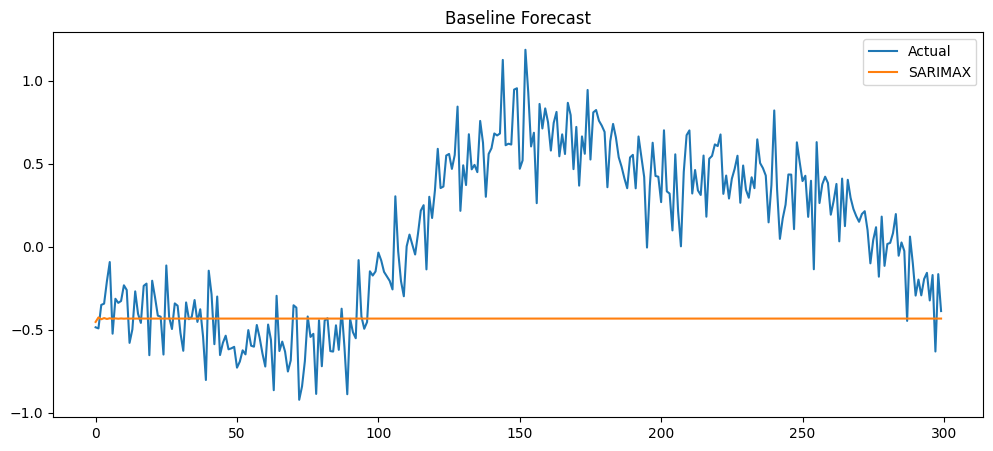

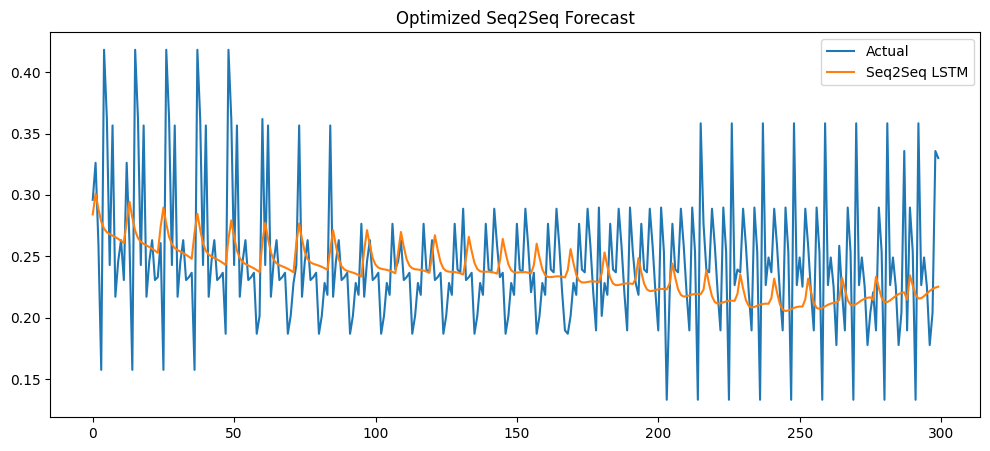

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(test_df["target"].values[:300], label="Actual")
plt.plot(baseline_forecast.values[:300], label="SARIMAX")
plt.legend()
plt.title("Baseline Forecast")
plt.show()


plt.figure(figsize=(12, 5))
plt.plot(y_test.flatten()[:300], label="Actual")
plt.plot(final_predictions.flatten()[:300], label="Seq2Seq LSTM")
plt.legend()
plt.title("Optimized Seq2Seq Forecast")
plt.show()

FINAL TEXT OUTPUT FOR SUBMISSION

In [18]:
print("FINAL OPTIMIZED HYPERPARAMETERS")
for k, v in best_params.items():
    print(f"{k}: {v}")

FINAL OPTIMIZED HYPERPARAMETERS
units: 64
layers: 2
lr: 0.0004599756485391123
batch: 64
